In [1]:
# Set the working directory to the parent directory
import sys
sys.path.append('..')
sys.dont_write_bytecode = True

import os
os.chdir("..")

# Import relevant packages
from src.eda import data_info
from src.explainability import *

# Import necessary libraries
import shap
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'  # or other, 'dejavuserif'
plt.rcParams['font.family'] = 'serif'  # or 'DejaVu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # 'DejaVu Serif' serif' 'Times'
plt.rcParams['font.size'] = 9

In [2]:
# Chosen tuning objective
metric = "AUC"

In [3]:
shap_dict = {}

for model_type in ["baseline", "dpsgd"]:
    # Initialize the SHAP explainer
    shap_init = ShapKernelExplainer(model_type=model_type, metric=metric)
    # Get the model version and predictions
    for i, row in shap_init.model_info.iterrows():
        version = row["version"]
        try:
            explanation = pd.read_feather(f"results/explainability/{model_type}/{version}_fixed.feather").values
        except FileNotFoundError:
            explanation = []
        if model_type == "baseline":
            eps = None
        else:
            eps = row['epsilon']
        shap_dict[(model_type, version, eps)] = explanation

X_test = shap_init.X_test.values
all_cols = shap_init.all_cols

## 1. Visualize the SHAP values

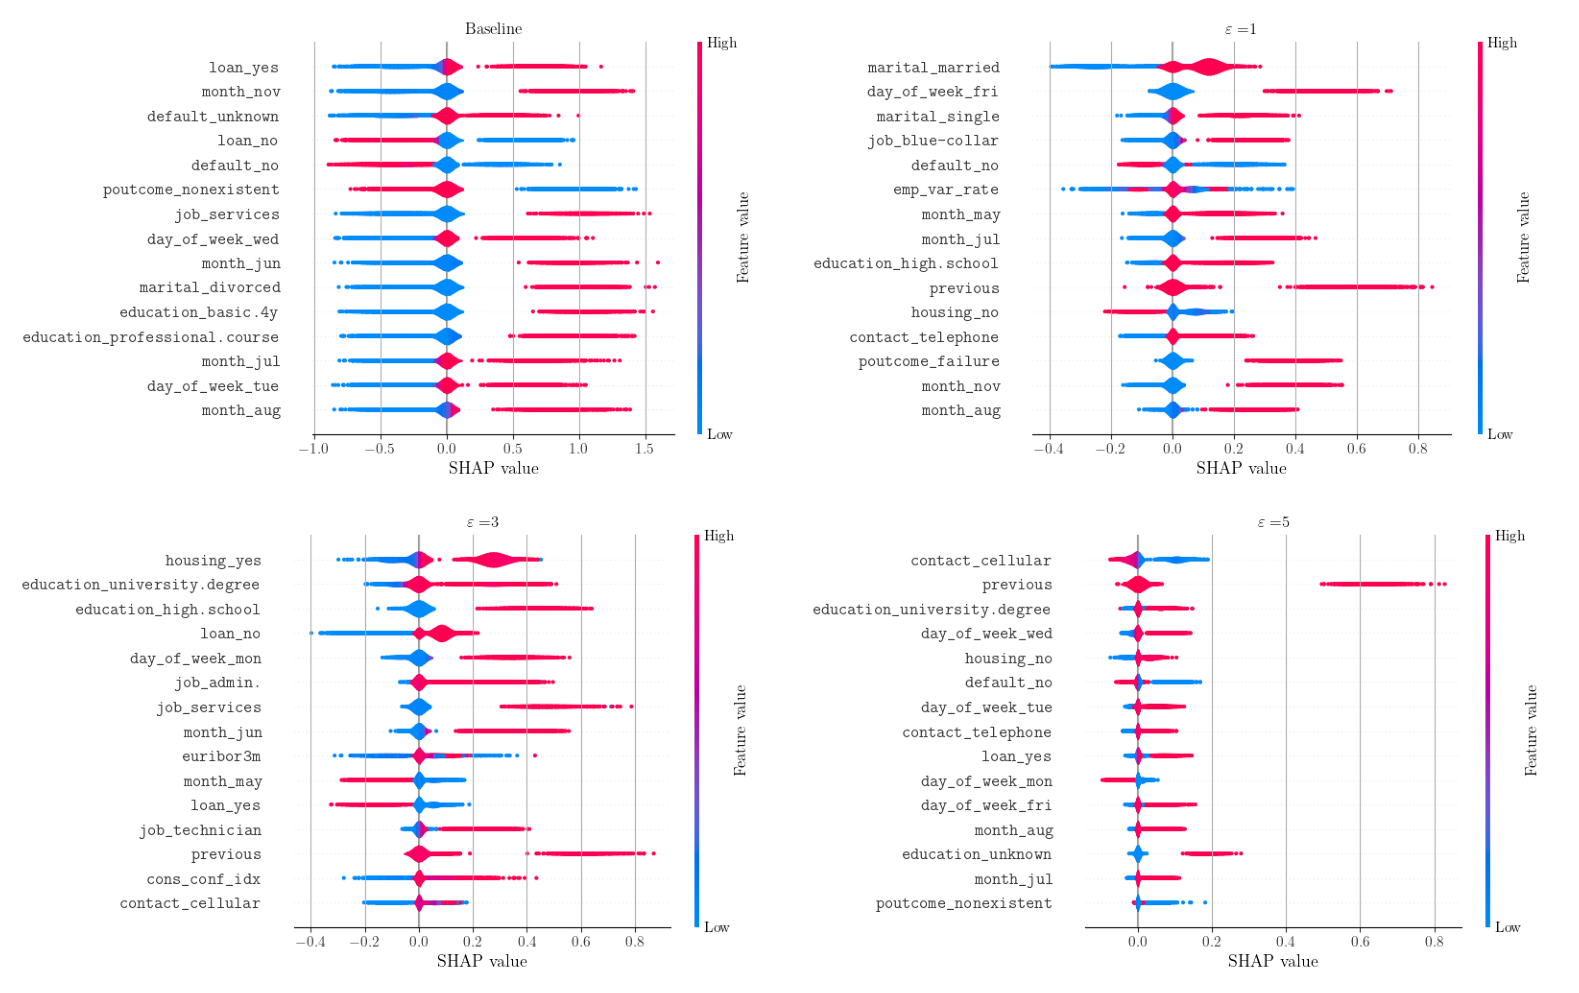

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))  # 2 rows x 2 cols
# Flatten the axes array for easier indexing
axes = axes.flatten()
j = 0

for (model_type, version, eps), explanation in shap_dict.items():
    # Get the model predictions
    y_pred = pd.read_feather(f"experiments/predictions/{model_type}/{version}_pred.feather")
    # Get the input of anomalies
    #x_anomaly = shap_init.X_test[y_pred['anomaly']==1].values
    # Get the SHAP values
    if explanation == []:
        continue
    else:
        shap_values = explanation
    # Plot the SHAP values
    if model_type == "baseline":
        title = "Baseline"
    else:
        title = r"$\varepsilon =$" + f"{eps:.0f}"
    # Create a temporary figure
    temp_fig = plt.figure()
    shap.summary_plot(shap_values,
                features=X_test,
                feature_names=[f"\\texttt{{{col}}}" for col in all_cols],
                show=False,
                plot_size=(8, 5),
                max_display=15,
                plot_type="violin",
                title=title,
                )
    # Draw the canvas, copy contents, and close temp
    temp_fig.canvas.draw()
    image = np.frombuffer(temp_fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(temp_fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(temp_fig)

    # Show the image in the target subplot
    axes[j].imshow(image)
    axes[j].axis("off")
    j += 1

plt.tight_layout()
plt.savefig(f"results/figures/shap_values.png", bbox_inches='tight', dpi=300)
plt.show()

## 2. SHAPGap

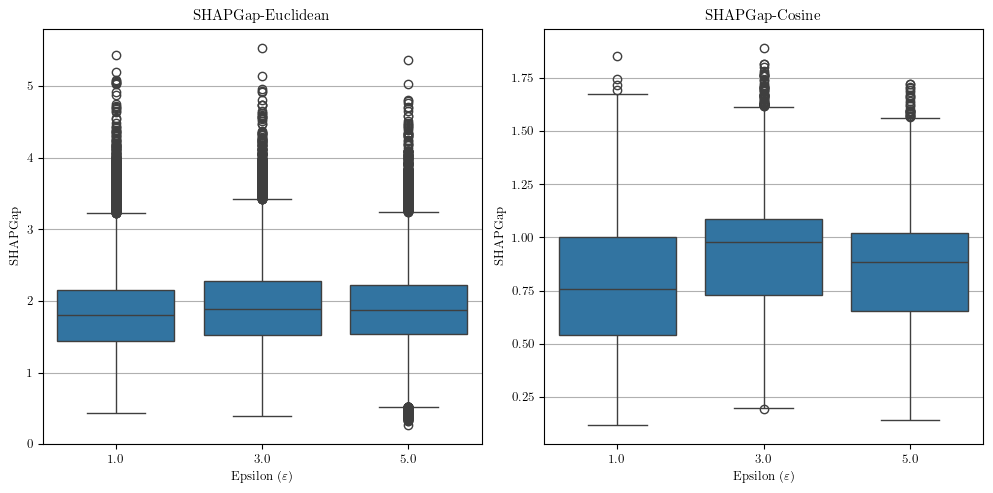

In [11]:
# Plot the SHAP values for the baseline and DPSGD models
records = []

for (model_type, version, eps), explanation in shap_dict.items():
    if model_type == "baseline":
        baseline_explanation = explanation

for (model_type, version, eps), explanation in shap_dict.items():
    if model_type == "dpsgd":
        dpsgd_explanation = explanation
        for gap_type in ["euclidean", "cosine"]:
            if gap_type == "euclidean":
                baseline_explanation_norm = normalize_shap(baseline_explanation, method="zscore")
                dpsgd_explanation_norm = normalize_shap(dpsgd_explanation, method="zscore")
            else:
                baseline_explanation_norm = normalize_shap(baseline_explanation, method="l2")
                dpsgd_explanation_norm = normalize_shap(dpsgd_explanation, method="l2")
            gap = shap_gap(baseline_explanation, dpsgd_explanation, gap_type=gap_type)
            records.append({
                "epsilon": eps,
                "gap_type": gap_type,
                "shap_gap": gap
            })

# Convert to DataFrame for seaborn
df = pd.DataFrame(records)

# Explode the 'shap_gap' column so that each list item becomes a row
df_melted = df.explode("shap_gap").reset_index(drop=True)

# Convert shapgap values to float (they may be stored as objects/strings)
df_melted["shap_gap"] = df_melted["shap_gap"].astype(float)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot each gap type
for i, gap_type in enumerate(["euclidean", "cosine"]):
    
    sns.boxplot(data=df_melted[df_melted["gap_type"] == gap_type],
                x="epsilon", y="shap_gap", ax=axes[i])
    axes[i].set_title(f"SHAPGap-{gap_type.capitalize()}")
    axes[i].set_xlabel(r"Epsilon ($\varepsilon$)")
    axes[i].set_ylabel("SHAPGap")
    axes[i].grid(axis='y')

plt.tight_layout()
plt.savefig(f"results/figures/shap_gap.png", bbox_inches='tight', dpi=300)
plt.show()

In [9]:
df_melted.groupby(["gap_type", "epsilon"]).agg(["mean", "std"])

shap_gap          
                        mean       std
gap_type  epsilon                     
cosine    1.0       0.769955  0.280663
          3.0       0.920328  0.272140
          5.0       0.843060  0.257777
euclidean 1.0       9.259496  4.715722
          3.0      10.037088  4.370185
          5.0       9.572399  4.441800